# Import libraries

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import mlflow
import scipy

# Import data

In [2]:
expenditure_df = pd.read_csv('../data/energy_cost.csv')

# Split data using KS-test

In [97]:
for i in range(40000):
    training_data, holdout_data = train_test_split(expenditure_df, test_size=0.15, random_state=i+1)
    _, p_value_energy = scipy.stats.kstest(training_data["energy_cost"], holdout_data["energy_cost"])
    _, p_value_gradient = scipy.stats.kstest(training_data["gradient"], holdout_data["gradient"])

    check_1 = p_value_energy >= 0.95
    check_2 = p_value_gradient >= 0.95

    if check_1 and check_2:
        print('Random state: ', i+1)
        training_data.to_csv("training_set.csv")
        holdout_data.to_csv("holdout_data.csv")
        break

Random state:  45


# Model training using mlflow

In [98]:

X_train = training_data['gradient']
y_train = training_data['energy_cost']
X_test = holdout_data['gradient']
y_test = holdout_data['energy_cost']


# create/set experiment name
mlflow.set_tracking_uri("./mlruns")
mlflow.set_experiment('SVM')

C_range = [0.01, 0.03, 0.05, 0.08, 0.1, 0.3, 0.5, 0.8, 1, 3, 5, 8, 10, 30, 50, 80, 100, 300, 500, 800, 1000, 3000, 5000]
gamma_range = ['scale', 'auto', 0.01, 0.03, 0.05, 0.08, 0.1, 0.3, 0.5, 0.8, 1, 3, 5, 8, 10, 30, 50, 80, 100, 300, 500, 800, 1000, 3000, 5000]

count = 0

for C in C_range:
    for gamma in gamma_range:
        with mlflow.start_run():
                    start = time.time()
                    count += 1
                    print(
                        "######################### Iteration Nr: {} ##############################".format(count))

                    # log hyperparameters
                    mlflow.log_param("C", C)
                    mlflow.log_param("gamma", gamma)

                    scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error']
                    params = {
                                "C": C,
                                "gamma": gamma,
                                }

                    fit_parameters = {"verbose": False}
                    model = SVR(**params)
                    scores = cross_validate(estimator=model, X=np.array(X_train).reshape(-1, 1), y=y_train, scoring=scoring, cv=5)
                    model.fit(X=np.array(X_train).reshape(-1, 1), y=y_train)
                    y_pred_train = model.predict(np.array(X_train).reshape(-1, 1))
                    y_pred_test = model.predict(np.array(X_test).reshape(-1, 1))
                    
                    mae_training = mean_absolute_error(y_train, y_pred_train)
                    mse_training = mean_squared_error(y_train, y_pred_train)

                    mae_validation = -1.0 * (scores["test_neg_mean_absolute_error"].mean())
                    mse_validation = -1.0 * (scores["test_neg_root_mean_squared_error"].mean())
                    
                    mae_test = mean_absolute_error(y_test, y_pred_test)
                    mse_test = mean_squared_error(y_test, y_pred_test)

                    mlflow.log_metric('Training MAE', mae_training)
                    mlflow.log_metric('Training RMSE', mse_training)
                    mlflow.log_metric('Validation MAE', mae_validation)
                    mlflow.log_metric('Validation RMSE', mse_validation)
                    mlflow.log_metric('Abs diff MAE', np.absolute(mae_validation - mae_training))
                    mlflow.log_metric('Abs diff RMSE', np.absolute(mse_validation - mse_training))
                    mlflow.log_metric('Holdout MAE', mae_test)
                    mlflow.log_metric('Holdout RMSE', mse_test)

2023/10/15 12:48:37 INFO mlflow.tracking.fluent: Experiment with name 'SVM' does not exist. Creating a new experiment.


######################### Iteration Nr: 1 ##############################
######################### Iteration Nr: 2 ##############################
######################### Iteration Nr: 3 ##############################
######################### Iteration Nr: 4 ##############################
######################### Iteration Nr: 5 ##############################
######################### Iteration Nr: 6 ##############################
######################### Iteration Nr: 7 ##############################
######################### Iteration Nr: 8 ##############################
######################### Iteration Nr: 9 ##############################
######################### Iteration Nr: 10 ##############################
######################### Iteration Nr: 11 ##############################
######################### Iteration Nr: 12 ##############################
######################### Iteration Nr: 13 ##############################
######################### Iteration Nr: 14 ####

# Visualise best model with data

In [3]:
# Build a model to predict energy expenditure based on gradient
X = expenditure_df['gradient'].values.reshape(-1, 1)
y = expenditure_df['energy_cost'].values
model = SVR(C=800, gamma=8)
model.fit(X, y)

# Generate a range of gradient values for prediction
X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

# Use the model to predict energy expenditure for these gradient values
y_pred = model.predict(X_pred)

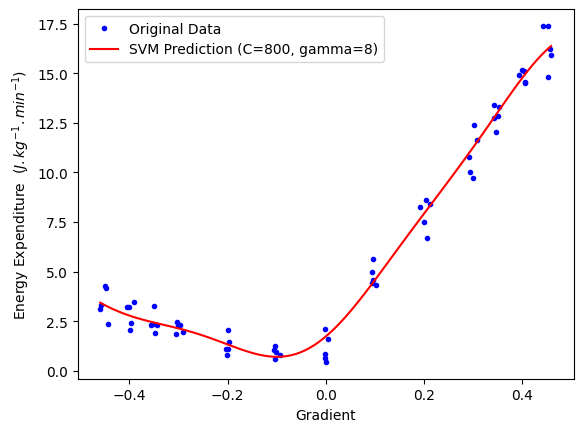

In [6]:
# Plot and save original data points
plt.plot(X, y, '.', label='Original Data', color='blue')
plt.plot(X_pred, y_pred, '-', label=r'SVM Prediction (C=800, gamma=8)', color='red')
plt.xlabel('Gradient')
plt.ylabel(r'Energy Expenditure  ($J.kg^{-1}.min^{-1}$)')
plt.legend()
plt.savefig('../model_training/model_prediction.png', dpi=1000, bbox_inches='tight')